In [1]:
import flopy
import pathlib as pl
from flopy.utils import GridIntersect, Raster
from shapely.geometry import Polygon

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
import flopy.utils.binaryfile as bf
from pathlib import Path
from flopy.discretization import UnstructuredGrid

In [2]:
flopy.__version__

'3.8.0'

In [3]:
sim = flopy.mfusg.MfUsg(modelname='Riv_11_usgnest_trans6_PP16_bpa4sp2', exe_name="../Executable/USGs_1.exe")

In [4]:
m=sim.load(
    'Riv_11_usgnest_trans6_PP16_bpa4sp2.nam',
    exe_name = "../Executable/USGs_1.exe",
    verbose=False,
    model_ws = '.',
    load_only=["DISU", "BAS6", "SMS", "LPF", "OC", "RIV", "GNC", "GHB", "CHD", "RCH", "EVT"],
    forgive=False,
    check=True,
)

In [5]:
m.write_input()

In [6]:
success, buff = m.run_model()

FloPy is using the following executable to run the model: ..\Executable\USGs_1.exe

                                  USG-TRANSPORT 
    MODFLOW-USG GROUNDWATER FLOW AND TRANSPORT MODEL
                             Version USG-TRANSPORT VERSION 2.4.0             

 Using NAME file: Riv_11_usgnest_trans6_PP16_bpa4sp2.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/09/30 14:10:37

 Solving:  Stress period:     1    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Groundwater Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/09/30 14:13:03
 Elapsed run time:  2 Minutes, 25.466 Seconds

  Normal termination of simulation


In [7]:
m.disu


    MODFLOW Unstructured Discretization Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.mfusg.MfUsg`) to which
        this package will be added.
    nodes : int
        Number of nodes in the model grid (default is 2).
    nlay : int
        Number of layers in the model grid (default is 1).
    njag : int
        Total number of connections of an unstructured grid. njag is used to
        dimension the sparse matrix in a compressed row storage format. For
        symmetric arrays, only the upper triangle of the matrix may be
        entered. For that case, the symmetric portion (minus the diagonal
        terms) is dimensioned as njags = (njag - nodes) / 2.
        (default is None).
    ivsd : int
        is the vertical sub-discretization index. For purposes of this flag,
        vertical sub-discretization is defined to occur when all layers are
        not a stacked representation of each other.
        If I

In [8]:
m.get_package_list()

['DISU', 'BAS6', 'SMS', 'OC', 'GNC', 'RCH', 'EVT', 'RIV', 'GHB', 'CHD', 'LPF']

In [9]:
file_name = "Riv_11_usgnest_trans6_PP16_bpa4sp2.gsf"
model_ws = Path.cwd().parent / "./reg_model_rvt_usg_flopy" / file_name

In [10]:
mfgrid = UnstructuredGrid.from_gridspec(model_ws)

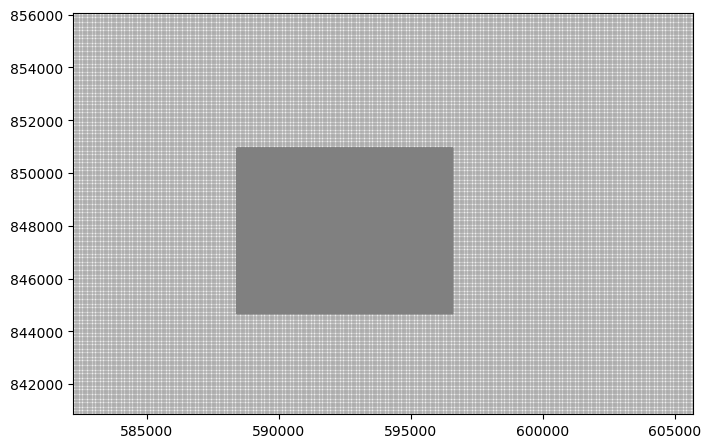

In [11]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(modelgrid=mfgrid, ax=ax)
pmv.plot_grid(alpha=0.1)

In [12]:
a=m.disu.top.array

In [13]:
np.unique(a)

array([   0.   , 4903.054, 4903.062, ..., 5067.384, 5067.757, 5068.14 ],
      dtype=float32)

In [14]:
b = m.disu.bot.array

In [15]:
np.unique(b)

array([-5.000000e-01,  0.000000e+00,  4.891055e+03, ...,  4.956098e+03,
        4.956341e+03,  4.956378e+03], dtype=float32)

In [70]:
hds = flopy.utils.HeadUFile("Riv_11_usgnest_trans6_PP16_bpa4sp2.hds", model=m)

In [71]:
head = np.array(hds.get_data(kstpkper=(0, 0)))

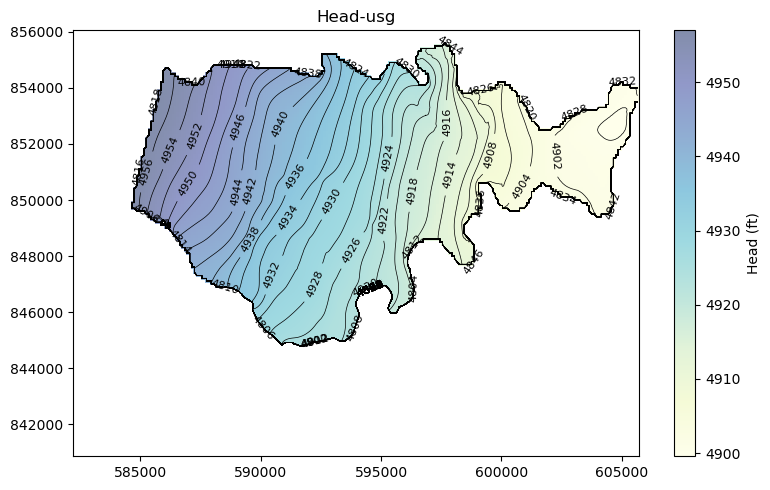

In [81]:
masked_head_array = np.ma.masked_where(head <= 4800, head)

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title("Head-usg")

pmv = flopy.plot.PlotMapView(modelgrid=mfgrid, ax=ax)

levels = np.arange(4800, 5000, 2)

img = pmv.plot_array(masked_head_array, alpha=0.5, cmap= 'YlGnBu', edgecolor='none')
cbar = plt.colorbar(img, ax=ax, label='Head (ft)')

contour = pmv.contour_array(masked_head_array, levels=levels, colors='black', linewidths=0.5, linestyles='None')
clabels = plt.clabel(contour, fontsize=8, fmt='%.0f')
plt.tight_layout()

plt.savefig('heads_usg.png', dpi=300)
plt.show()

In [55]:
hds.get_kstpkper()

[(0, 0), (0, 1), (0, 2), (0, 3)]

In [56]:
hds.get_times()

[2015.0, 2016.0, 2017.0, 2018.0]

In [57]:
head_array = np.array(head)
np.savetxt("head_values_usg.txt", head_array, delimiter=",", newline="\n")

In [58]:
np.unique(head)

array([ 999.    , 4577.224 , 4899.329 , ..., 4956.9985, 4956.9995,
       4957.    ], dtype=float32)

In [60]:
hds.headers

,kstp,kper,pertim,totim,text,ncol,nrow,ilay
44,1,1,2015.0,2015.0,HEADU,1,547154,1
2188704,1,2,1.0,2016.0,HEADU,1,547154,1
4377364,1,3,1.0,2017.0,HEADU,1,547154,1
6566024,1,4,1.0,2018.0,HEADU,1,547154,1


In [62]:
print(type(head_array))

<class 'numpy.ndarray'>


In [63]:
bas6 = m.get_package("bas6")
ibound = bas6.ibound.array

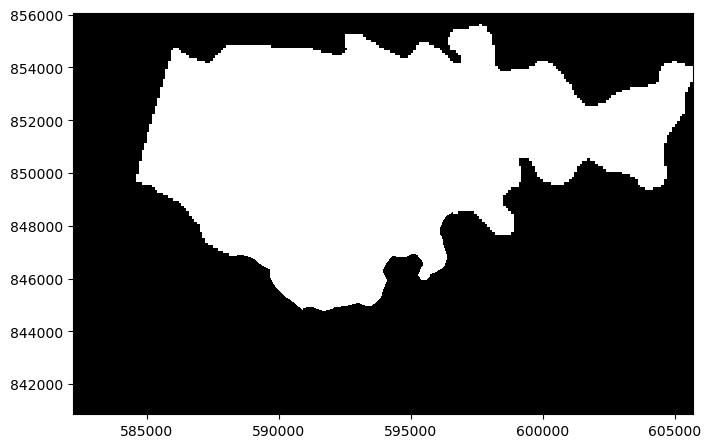

In [64]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(modelgrid=mfgrid, ax=ax)
inac = pmv.plot_inactive(ibound=ibound)

In [300]:
print(type(m))

<class 'flopy.mfusg.mfusg.MfUsg'>


In [109]:
lpf = m.get_package("lpf")
hk = m.lpf.hk.array

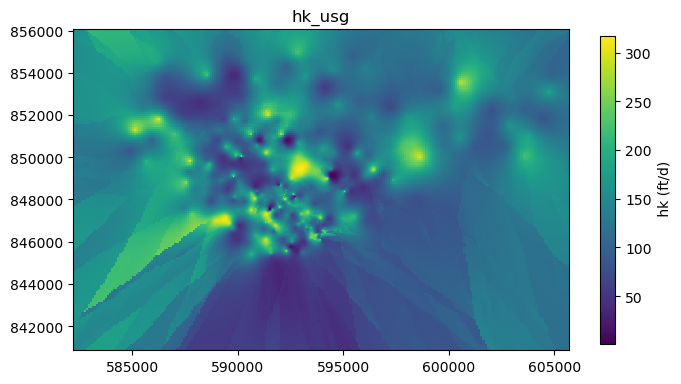

In [133]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(modelgrid=mfgrid, ax=ax)
k = pmv.plot_array(a=hk, masked_values=None)
cbar = plt.colorbar(k, ax=ax, shrink=0.5)
cbar.set_label(' hk (ft/d)')
ax.set_title('hk_usg') 

plt.savefig('hk_usg.png', dpi=300)
plt.show()